# Environment check (and optional install)

In [1]:
import sys, os, platform, subprocess, json
from collections import Counter, defaultdict
from src.utils.assertion_tests import check_image_mask_pairs
import os, csv, re, random
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#import tensorflow as tf
print("Python:", sys.version)
print("Platform:", platform.platform())

try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    print("GPU Available:", len(tf.config.list_physical_devices("GPU")) > 0)
except Exception as e:
    print("TensorFlow not installed yet:", e)

# Optional: install repo dependencies inside this kernel (run once if needed)
#subprocess.run([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"], check=False)

Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.19045-SP0
TensorFlow: 2.10.0
GPU Available: True


# Configure paths & hyperparameters

In [2]:
# <<< EDIT ME >>>
ROOT_DATA = "data"   # Parent folder containing your PV01/PV03/PV08 folders
SPLITS_CSV = "data/segmentation/splits.csv"
MASK_SUFFIX = "_label"                   # Change if your masks use a different suffix

# Training params
IMG_SIZE = 128
BATCH    = 24
EPOCHS   = 8
RUN_DIR  = "reports/seg_unet"           # Where training outputs will go


# Build 60/20/20 splits for segmentation

In [3]:
import sys, subprocess, os
os.makedirs(os.path.dirname(SPLITS_CSV), exist_ok=True)

cmd = [
    sys.executable, "-m", "src.data_prep.make_splits",
    "--mode", "seg",
    "--root", ROOT_DATA,
    "--out", SPLITS_CSV,
    "--seg_same_dir",
    "--mask_suffix", MASK_SUFFIX,
    "--img_exts", ".bmp,.png,.jpg",
    "--mask_exts", ".bmp,.png,.jpg",
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Done ->", SPLITS_CSV)


Running: c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.data_prep.make_splits --mode seg --root data --out data/segmentation/splits.csv --seg_same_dir --mask_suffix _label --img_exts .bmp,.png,.jpg --mask_exts .bmp,.png,.jpg
Done -> data/segmentation/splits.csv


# Quick peek at the CSV

In [4]:
df = pd.read_csv(SPLITS_CSV)
df.head()

,split,image_path,mask_path
0,train,data\PV01\PV01_Rooftop_Brick\PV01_325373_12038...,data\PV01\PV01_Rooftop_Brick\PV01_325373_12038...
1,train,data\PV08\PV08_Ground\PV08_327808_1209367.bmp,data\PV08\PV08_Ground\PV08_327808_1209367_labe...
2,train,data\PV03\PV03_Ground_Cropland\PV03_341693_119...,data\PV03\PV03_Ground_Cropland\PV03_341693_119...
3,train,data\PV03\PV03_Ground_Cropland\PV03_336536_120...,data\PV03\PV03_Ground_Cropland\PV03_336536_120...
4,train,data\PV03\PV03_Ground_Cropland\PV03_348066_116...,data\PV03\PV03_Ground_Cropland\PV03_348066_116...


In [5]:
# assertion test for the image_path vs mask_path alignment.
check_image_mask_pairs(df)

All filenames for image path and mask path pairs are aligned (similarity >= 0.60).


# Visual sanity check (a few image/mask pairs)

data\PV03\PV03_Ground_Cropland\PV03_340237_1175834.bmp : data\PV03\PV03_Ground_Cropland\PV03_340237_1175834_label.bmp


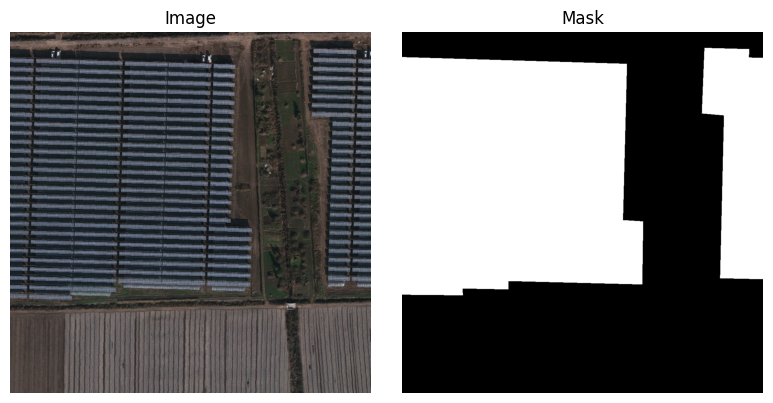

data\PV08\PV08_Ground\PV08_325286_1210648.bmp : data\PV08\PV08_Ground\PV08_325286_1210648_label.bmp


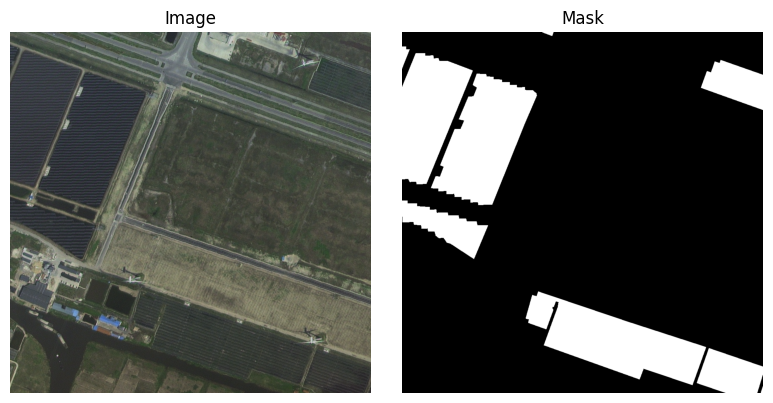

data\PV03\PV03_Rooftop\PV03_322023_1196820.bmp : data\PV03\PV03_Rooftop\PV03_322023_1196820_label.bmp


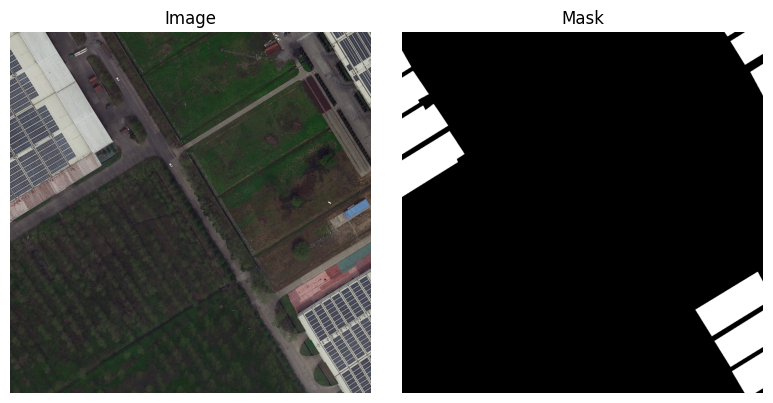

data\PV08\PV08_Ground\PV08_344242_1186820.bmp : data\PV08\PV08_Ground\PV08_344242_1186820_label.bmp


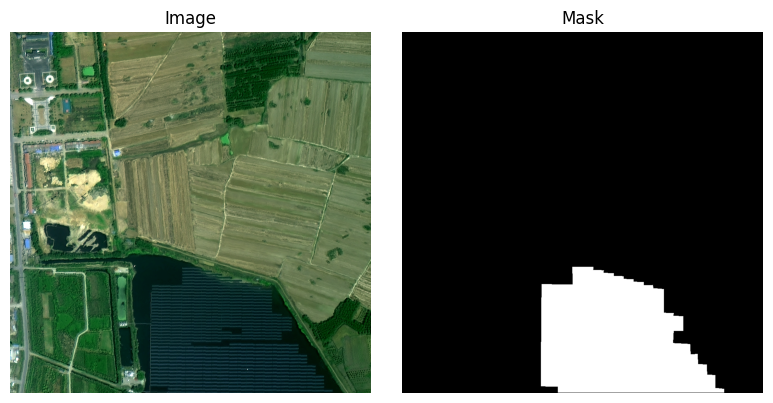

data\PV08\PV08_Ground\PV08_347988_1166535.bmp : data\PV08\PV08_Ground\PV08_347988_1166535_label.bmp


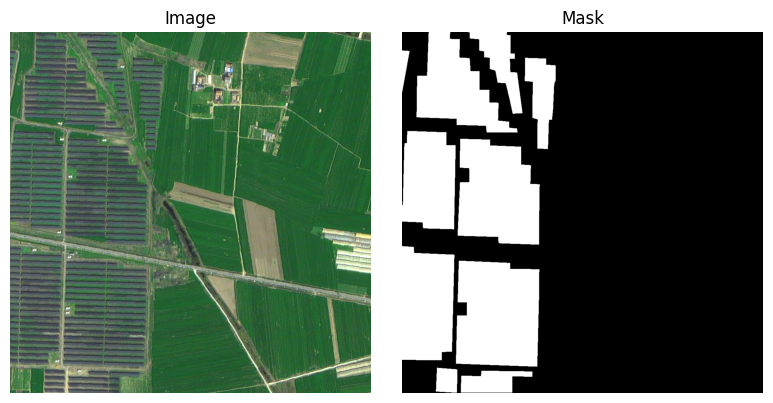

data\PV03\PV03_Ground_Cropland\PV03_331853_1195599.bmp : data\PV03\PV03_Ground_Cropland\PV03_331853_1195599_label.bmp


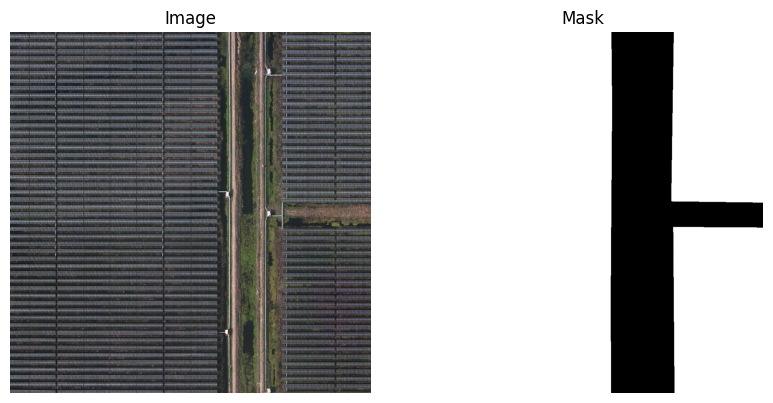

In [6]:
def show_image_and_mask(img_path, mask_path):
    """Display image and mask side by side using PIL.Image."""
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')  # convert mask to grayscale
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()
    return img, mask  # Return for optional further use

sub = df[df["split"]=="train"].sample(n=min(6, len(df)))
for _, r in sub.iterrows():
    print(f"{r.image_path} : {r.mask_path}")
    img, msk = show_image_and_mask(r.image_path, r.mask_path)

# Train segmentation (U-Net + MobileNetV2 encoder)

In [7]:
os.makedirs(RUN_DIR, exist_ok=True)

cmd = [
    sys.executable, "-m", "src.seg.train_seg",
    "--csv", SPLITS_CSV, "--out", RUN_DIR,
    "--epochs", str(EPOCHS), "--batch", str(BATCH), "--img", str(IMG_SIZE),
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Saved model & logs in:", RUN_DIR)


Running: c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.seg.train_seg --csv data/segmentation/splits.csv --out reports/seg_unet --epochs 8 --batch 24 --img 128
Saved model & logs in: reports/seg_unet


## Plot training history

,epoch,binary_accuracy,dice_coef,iou,loss,val_binary_accuracy,val_dice_coef,val_iou,val_loss
0,0,0.932496,0.028503,0.570683,0.210109,0.943166,0.058157,0.825124,0.087204
1,1,0.963191,0.070174,0.861396,0.065940,0.970070,0.082761,0.902177,0.061427
2,2,0.981361,0.095544,0.902347,0.044752,0.979305,0.101215,0.837682,0.054226
3,3,0.986894,0.112036,0.915358,0.033163,0.986339,0.121481,0.927838,0.034937
4,4,0.990112,0.121384,0.932642,0.025502,0.988878,0.125644,0.931237,0.027664
5,5,0.991100,0.126339,0.938796,0.022565,0.989743,0.126561,0.947701,0.025007
6,6,0.992038,0.128692,0.945489,0.020672,0.990222,0.129879,0.949490,0.024353
7,7,0.993144,0.133007,0.951226,0.017379,0.991150,0.129431,0.928354,0.023113


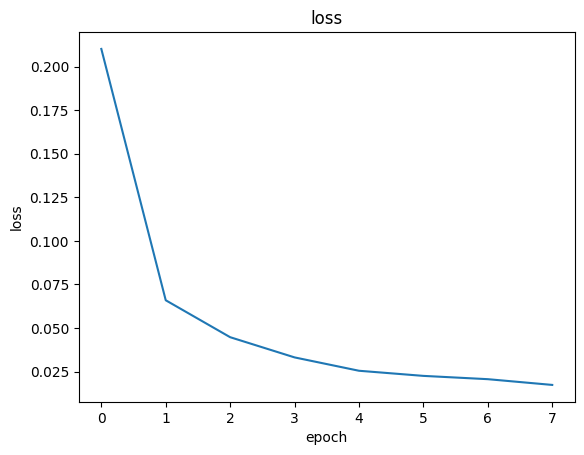

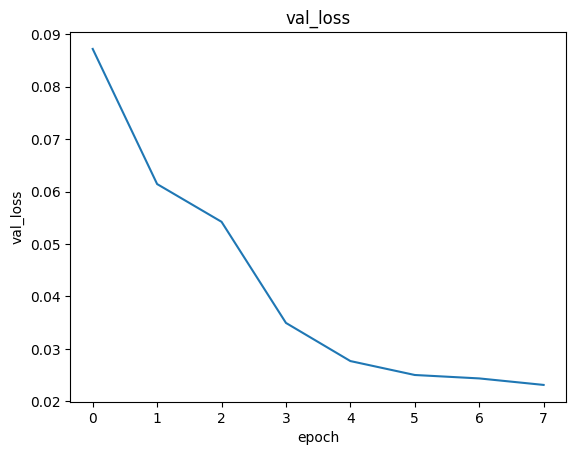

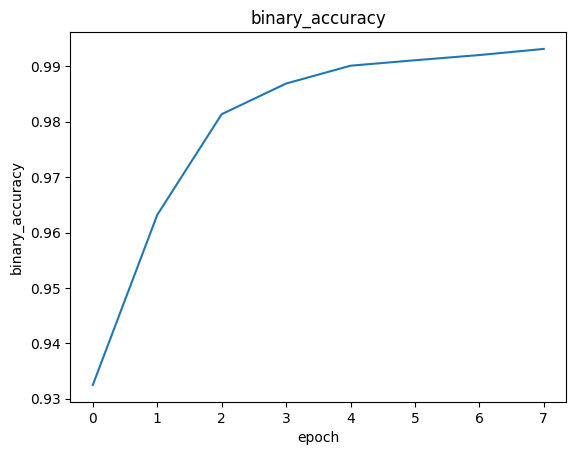

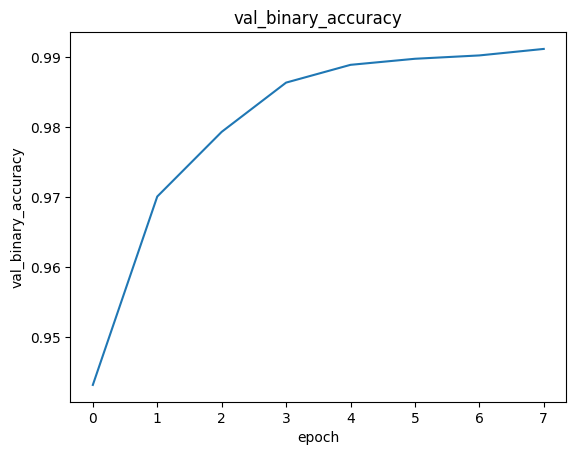

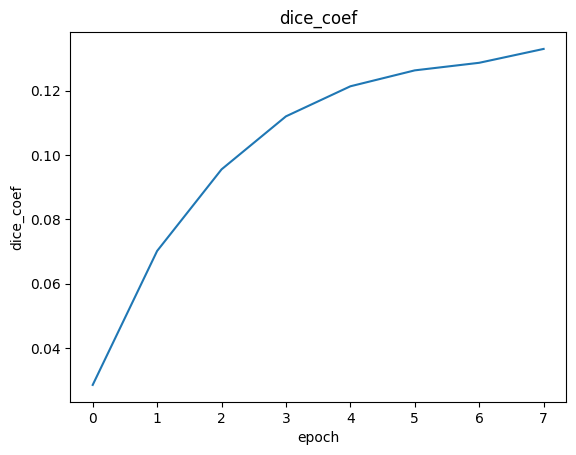

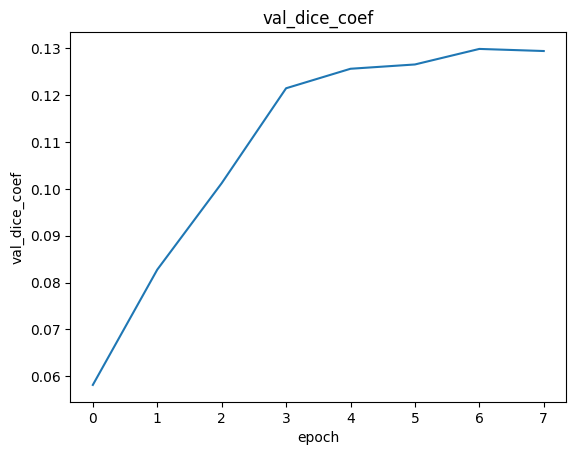

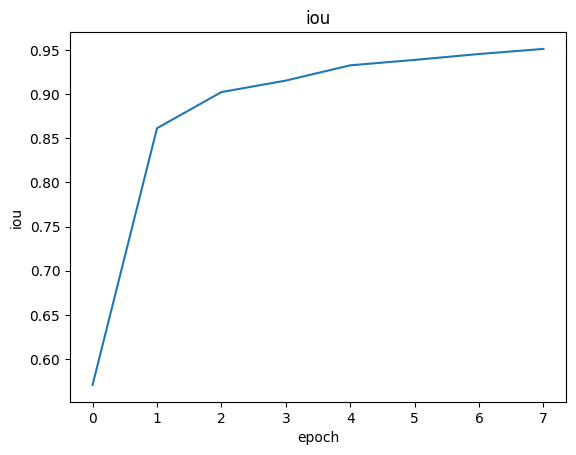

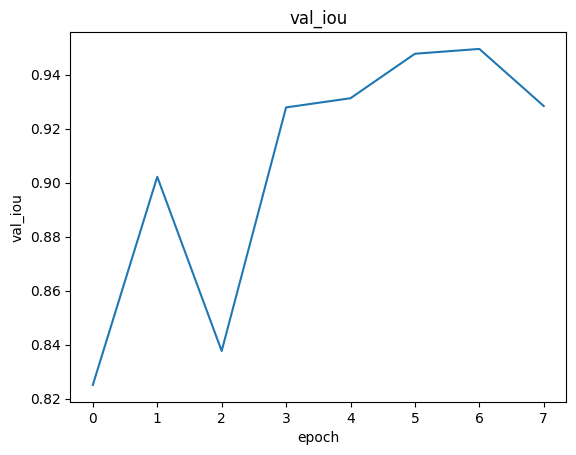

In [8]:
hist_path = os.path.join(RUN_DIR, "history.csv")
h = pd.read_csv(hist_path)
display(h.head(10))

for col in ["loss","val_loss","binary_accuracy","val_binary_accuracy","dice_coef","val_dice_coef","iou","val_iou"]:
    if col in h:
        plt.figure()
        plt.plot(h[col])
        plt.title(col)
        plt.xlabel("epoch"); plt.ylabel(col)
        plt.show()


# Evaluate on the test set

In [9]:
EVAL_DIR = os.path.join(RUN_DIR, "eval")
cmd = [
    sys.executable, "-m", "src.seg.eval_seg",
    "--csv", SPLITS_CSV,
    "--model", os.path.join(RUN_DIR, "best.keras"),
    "--out", EVAL_DIR,
    "--img", str(IMG_SIZE),
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)

with open(os.path.join(EVAL_DIR, "test_metrics.json"), "r") as f:
    metrics = json.load(f)
metrics


Running: c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.seg.eval_seg --csv data/segmentation/splits.csv --model reports/seg_unet\best.keras --out reports/seg_unet\eval --img 128


{'binary_accuracy': 0.990118145942688,
 'dice': 0.1319030225276947,
 'iou': 0.9114237427711487,
 'n_test': 744}

In [10]:
metrics.keys()

dict_keys(['binary_accuracy', 'dice', 'iou', 'n_test'])

In [11]:
metrics.values()

dict_values([0.990118145942688, 0.1319030225276947, 0.9114237427711487, 744])

In [12]:
pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['value'])

,value
binary_accuracy,0.990118
dice,0.131903
iou,0.911424
n_test,744.000000


# Visualising the Segmentation Results

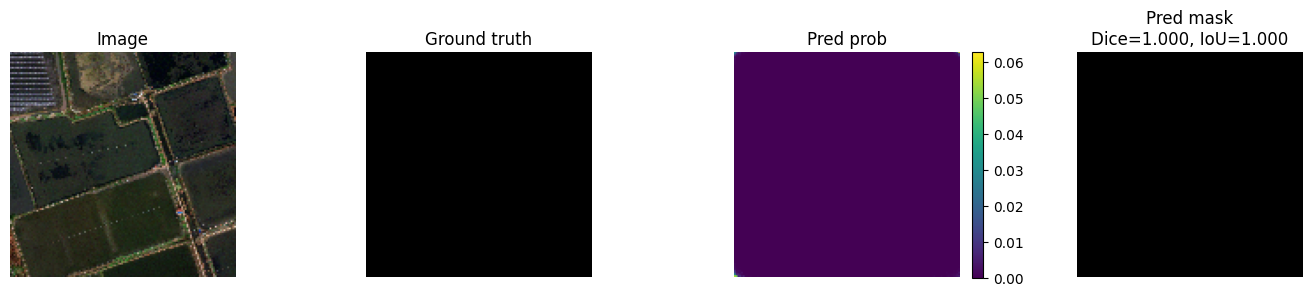

In [13]:
CSV         = "data/segmentation/splits.csv"
MODEL_PATH  = "reports/seg_unet/best.keras"   # or last.keras
IMG_SIZE    = 128                              # must match what you trained with
THRESH      = 0.5                              # binarization threshold for predictions

# --- BMP-safe loader (3-channel decode then grayscale for masks) ---
def load_image_mask_bmp_safe(img_path, msk_path, img_size):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # BMP/PNG/JPG
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.cast(img, tf.float32) / 255.0

    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_image(msk, channels=3, expand_animations=False)  # BMP-safe
    msk = tf.image.rgb_to_grayscale(msk)
    msk = tf.image.resize(msk, (img_size, img_size), method="nearest")
    msk = tf.cast(msk > 127, tf.float32)  # binarize GT
    return img.numpy(), msk.numpy().squeeze()

def dice_np(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = (y_true * y_pred).sum()
    return (2*inter + eps) / (y_true.sum() + y_pred.sum() + eps)

def iou_np(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = (y_true * y_pred).sum()
    union  = y_true.sum() + y_pred.sum() - inter
    return (inter + eps) / (union + eps)

# Load a random test sample
df = pd.read_csv(CSV)
test_df = df[df["split"] == "test"]
row = test_df.sample(2).iloc[0]

img, msk_true = load_image_mask_bmp_safe(row.image_path, row.mask_path, IMG_SIZE)

# Load model (no custom objects needed for inference)
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Predict
prob = model(tf.expand_dims(img, 0), training=False).numpy()[0, :, :, 0]
msk_pred = (prob >= THRESH).astype(np.float32)

# Metrics
d = dice_np(msk_true, msk_pred)
j = iou_np(msk_true, msk_pred)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].imshow(img);                  ax[0].set_title("Image");               ax[0].axis("off")
ax[1].imshow(msk_true, cmap="gray");ax[1].set_title("Ground truth");        ax[1].axis("off")
im = ax[2].imshow(prob, cmap="viridis"); ax[2].set_title("Pred prob");      ax[2].axis("off")
fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
ax[3].imshow(msk_pred, cmap="gray"); ax[3].set_title(f"Pred mask\nDice={d:.3f}, IoU={j:.3f}"); ax[3].axis("off")
plt.tight_layout(); plt.show()


# Classification Task

#### Available Models: inceptionv3_net_proposed, cnn_plain, mobilenetv3, densenet, vgg16, vgg19, resnet50, inceptionv3_base

## Train the Classifier Models

In [14]:
# Path to your classification CSV
CLS_CSV = "data/classification/splits_spfnet.csv"   # change if different

# Train *all* available classifiers from the repo
MODELS = [
    "cnn_plain",
    "mobilenetv3",
    "densenet",
    "vgg16",
    "vgg19",
    "resnet50",
    "inceptionv3_base",
    "inceptionv3_net_proposed",   # the "proposed" head (InceptionV3 backbone)
]

# Shared hyperparams
IMG    = 256
BATCH  = 32
EPOCHS = 30

# Where to dump all runs + summary
RUNS_ROOT = Path("reports/cls_runs")
RUNS_ROOT.mkdir(parents=True, exist_ok=True)

# Environment knobs (helps avoid GPU OOM & spam)
BASE_ENV = os.environ.copy()
BASE_ENV["TF_CPP_MIN_LOG_LEVEL"] = "2"                 # quiet TF logs
BASE_ENV["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"         # let TF grow GPU memory gradually


## Helper Functions

In [15]:
def run_training_and_eval(model_name, csv_path, img, batch, epochs, runs_root, base_env):
    """Train + eval one classifier; return (status, run_dir, metrics_dict or None, stderr_tail)."""
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = runs_root / f"{model_name}"
    run_dir.mkdir(parents=True, exist_ok=True)

    # 1) Train
    train_cmd = [
        sys.executable, "-m", "src.cls.train_cls",
        "--csv",   csv_path,
        "--model_name", model_name,
        "--out",   str(run_dir),
        "--epochs", str(epochs),
        "--batch",  str(batch),
        "--img",    str(img),
    ]
    print(f"\n=== Training {model_name} ===\n$ {' '.join(train_cmd)}")
    train_proc = subprocess.run(train_cmd, capture_output=True, text=True, env=base_env)
    print("---- TRAIN STDOUT (tail) ----\n", train_proc.stdout[-1500:])
    print("---- TRAIN STDERR (tail) ----\n", train_proc.stderr[-1500:])
    if train_proc.returncode != 0:
        return ("TRAIN_FAIL", str(run_dir), None, train_proc.stderr[-2000:])

    # 2) Eval
    eval_dir = run_dir / "eval"
    eval_cmd = [
        sys.executable, "-m", "src.cls.eval_cls",
        "--csv",   csv_path,
        "--model", str(run_dir / "best.keras"),
        "--out",   str(eval_dir),
        "--img",   str(img),
    ]
    print(f"\n=== Evaluating {model_name} ===\n$ {' '.join(eval_cmd)}")
    eval_proc = subprocess.run(eval_cmd, capture_output=True, text=True, env=base_env)
    print("---- EVAL STDOUT (tail) ----\n", eval_proc.stdout[-1500:])
    print("---- EVAL STDERR (tail) ----\n", eval_proc.stderr[-1500:])
    if eval_proc.returncode != 0:
        return ("EVAL_FAIL", str(run_dir), None, eval_proc.stderr[-2000:])

    # 3) Read metrics JSON if present
    metrics_path = eval_dir / "test_metrics.json"
    metrics = None
    if metrics_path.exists():
        try:
            with open(metrics_path, "r", encoding="utf-8") as f:
                metrics = json.load(f)
        except Exception as e:
            print("Could not read test_metrics.json:", e)

    return ("OK", str(run_dir), metrics, eval_proc.stderr[-1000:])


## Train and Evalual ALL classifoer models and build a summary table

In [16]:
results = []
failures = []

for m in MODELS:
    status, run_dir, metrics, err_tail = run_training_and_eval(
        model_name=m,
        csv_path=CLS_CSV,
        img=IMG,
        batch=BATCH,
        epochs=EPOCHS,
        runs_root=RUNS_ROOT,
        base_env=BASE_ENV
    )
    row = {
        "model": m,
        "status": status,
        "run_dir": run_dir,
        "acc": None,
        "macro_f1": None,
        "support": None,
    }
    if metrics:
        # Try to pull common fields; fall back gracefully if keys differ in your eval script
        row["acc"] = metrics.get("accuracy") or metrics.get("test_accuracy") or metrics.get("acc")
        row["macro_f1"] = metrics.get("macro_f1") or metrics.get("f1_macro")
        row["support"] = metrics.get("test_support") or metrics.get("n_test")
    else:
        if status != "OK":
            failures.append((m, status, err_tail))

    results.append(row)

summary_df = pd.DataFrame(results).sort_values(by=["status","acc"], ascending=[True, False])
display(summary_df)

# Save summary
summary_csv = RUNS_ROOT / "summary.csv"
summary_df.to_csv(summary_csv, index=False)
print("Saved summary ->", summary_csv)

if failures:
    print("\nSome models failed:")
    for m, st, err in failures:
        print(f"\n[{m}] {st}\n{err}")



=== Training cnn_plain ===
$ c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.cls.train_cls --csv data/classification/splits_spfnet.csv --model_name cnn_plain --out reports\cls_runs\cnn_plain --epochs 30 --batch 32 --img 256
---- TRAIN STDOUT (tail) ----
 3069 - val_accuracy: 0.4826
Epoch 17/30

17/17 [==============================] - 2s 134ms/step - loss: 1.3330 - accuracy: 0.4027 - val_loss: 1.3023 - val_accuracy: 0.4767

---- TRAIN STDERR (tail) ----
 

=== Evaluating cnn_plain ===
$ c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.cls.eval_cls --csv data/classification/splits_spfnet.csv --model reports\cls_runs\cnn_plain\best.keras --out reports\cls_runs\cnn_plain\eval --img 256
---- EVAL STDOUT (tail) ----
 Saved metrics and confusion matrix.

---- EVAL STDERR (tail) ----
 

=== Training mobilenetv3 ===
$ c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.cls.train_cls --csv data/classification/splits_spfnet.csv --mode

,model,status,run_dir,acc,macro_f1,support
5,resnet50,OK,reports\cls_runs\resnet50,0.254144,None,None
2,densenet,OK,reports\cls_runs\densenet,0.226519,None,None
0,cnn_plain,OK,reports\cls_runs\cnn_plain,0.215470,None,None
1,mobilenetv3,OK,reports\cls_runs\mobilenetv3,0.215470,None,None
6,inceptionv3_base,OK,reports\cls_runs\inceptionv3_base,0.215470,None,None
7,inceptionv3_net_proposed,OK,reports\cls_runs\inceptionv3_net_proposed,0.215470,None,None
3,vgg16,OK,reports\cls_runs\vgg16,0.138122,None,None
4,vgg19,OK,reports\cls_runs\vgg19,0.138122,None,None


Saved summary -> reports\cls_runs\summary.csv


# View the Performance Metrics for Each Model


TRAINING SUMMARY FOR: RESNET50
Final Training Accuracy: 0.9141
Final Validation Accuracy: 0.7674
Final Training Loss: 0.2587
Final Validation Loss: 1.0293
Best Validation Accuracy: 0.8023


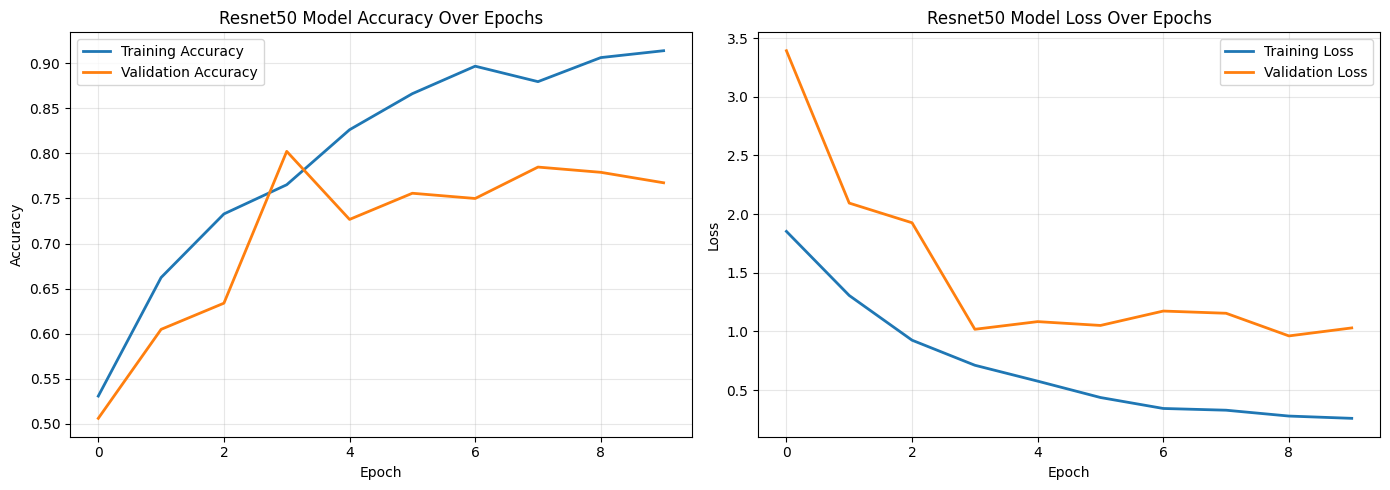


TRAINING SUMMARY FOR: DENSENET
Final Training Accuracy: 0.8492
Final Validation Accuracy: 0.6279
Final Training Loss: 0.4487
Final Validation Loss: 1.5347
Best Validation Accuracy: 0.6628


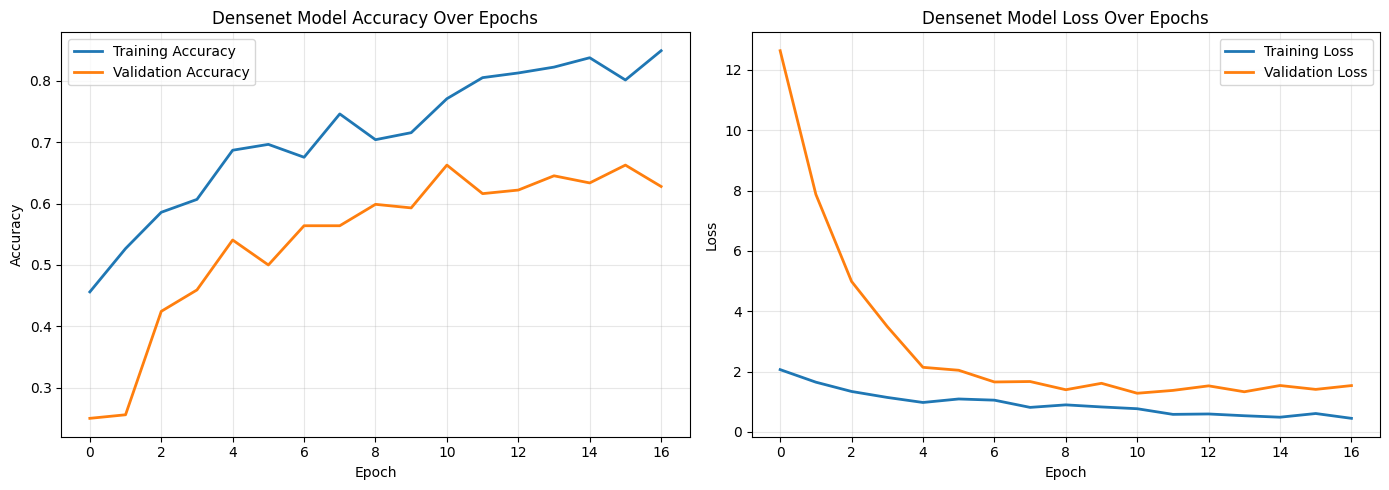


TRAINING SUMMARY FOR: CNN_PLAIN
Final Training Accuracy: 0.4027
Final Validation Accuracy: 0.4767
Final Training Loss: 1.3330
Final Validation Loss: 1.3023
Best Validation Accuracy: 0.5174


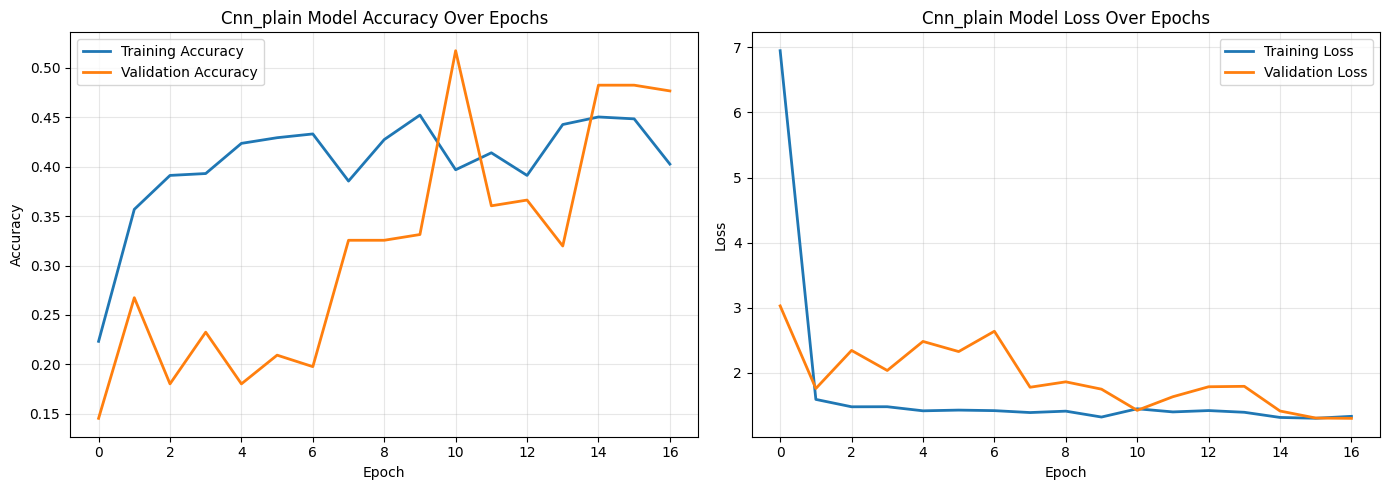


TRAINING SUMMARY FOR: MOBILENETV3
Final Training Accuracy: 0.9599
Final Validation Accuracy: 0.8198
Final Training Loss: 0.1424
Final Validation Loss: 0.8502
Best Validation Accuracy: 0.8314


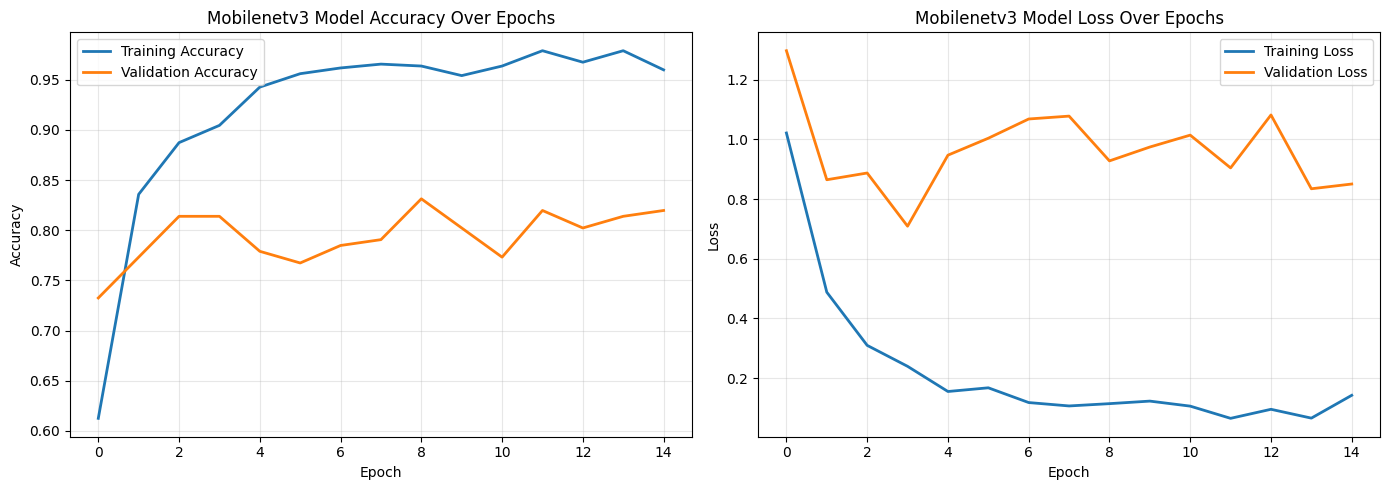


TRAINING SUMMARY FOR: INCEPTIONV3_BASE
Final Training Accuracy: 0.8321
Final Validation Accuracy: 0.7267
Final Training Loss: 0.4619
Final Validation Loss: 0.8017
Best Validation Accuracy: 0.7267


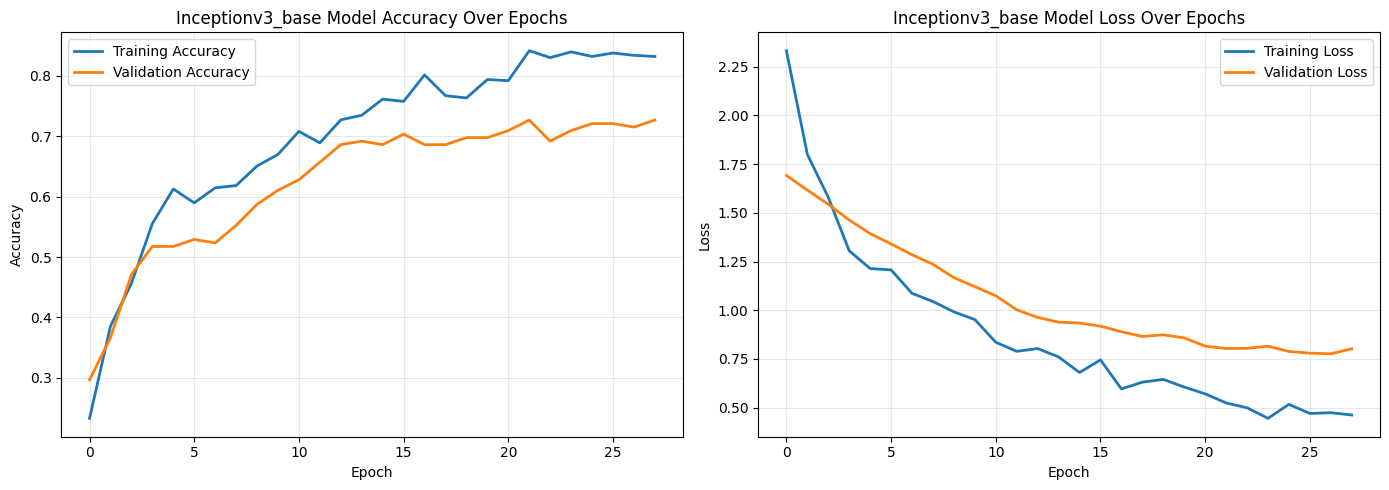


TRAINING SUMMARY FOR: INCEPTIONV3_NET_PROPOSED
Final Training Accuracy: 0.6851
Final Validation Accuracy: 0.5174
Final Training Loss: 0.9291
Final Validation Loss: 1.6281
Best Validation Accuracy: 0.5698


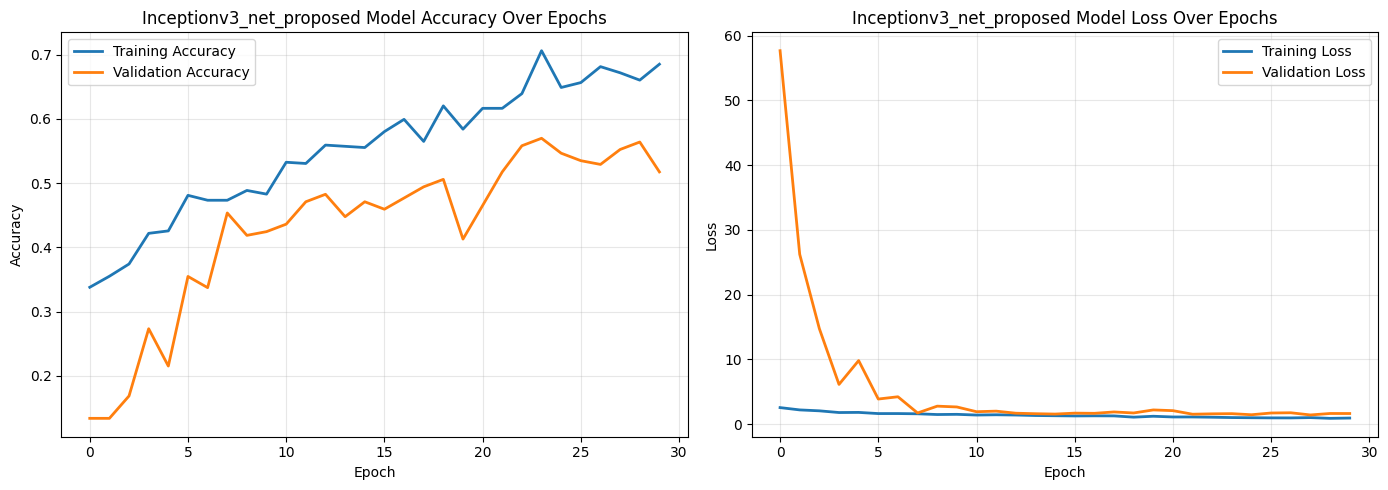


TRAINING SUMMARY FOR: VGG16
Final Training Accuracy: 0.9370
Final Validation Accuracy: 0.7267
Final Training Loss: 0.1668
Final Validation Loss: 1.4474
Best Validation Accuracy: 0.7384


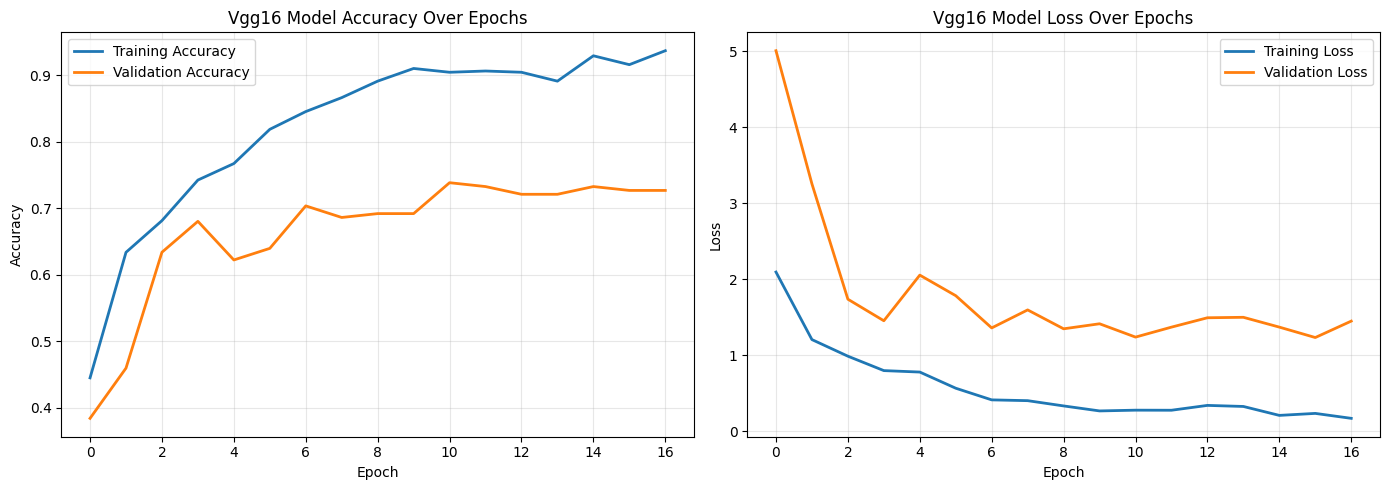


TRAINING SUMMARY FOR: VGG19
Final Training Accuracy: 0.9008
Final Validation Accuracy: 0.6802
Final Training Loss: 0.2959
Final Validation Loss: 1.7610
Best Validation Accuracy: 0.7500


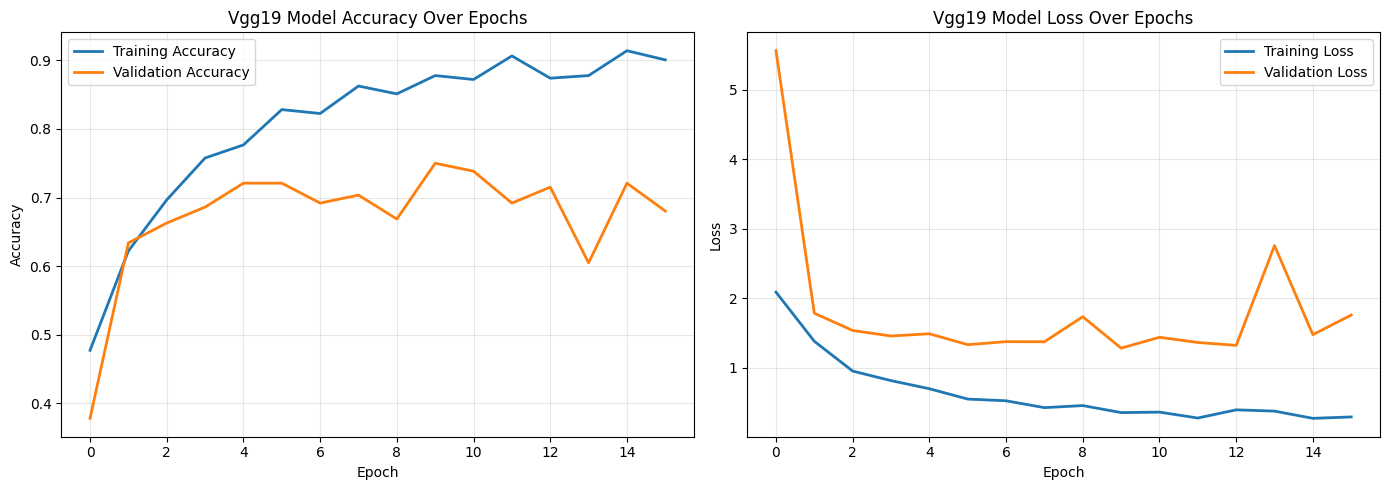

In [17]:
# epoch,accuracy,loss,val_accuracy,val_loss
for model in summary_df.model.tolist():
    path_ = f"reports/cls_runs/{model}/history.csv"
    history = pd.read_csv(path_)
    # Summary of results
    print(f"\n{'='*60}")
    print(f"TRAINING SUMMARY FOR: {model.upper()}")
    print(f"{'='*60}")
    print(f"Final Training Accuracy: {history['accuracy'].tolist()[-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_accuracy'].tolist()[-1]:.4f}")
    print(f"Final Training Loss: {history['loss'].tolist()[-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'].tolist()[-1]:.4f}")
    print(f"Best Validation Accuracy: {max(history['val_accuracy'].tolist()):.4f}")
    print(f"{'='*60}")
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title(f'{model.capitalize()} Model Accuracy Over Epochs')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'{model.capitalize()} Model Loss Over Epochs')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    